In [52]:
import os
import pickle
import re
import time
from datetime import date, datetime

from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns
from pandas.api.types import CategoricalDtype

from warnings import simplefilter
simplefilter('ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None

## Scrape WNBA 2024 Season Data

In [53]:
snapshot_url = 'https://www.basketball-reference.com/wnba/years/2024_games.html'
headers = {'User-Agent': 'Mozilla/5.0'}
snapshot_response = requests.get(snapshot_url, headers=headers)
status_code = snapshot_response.status_code  
print(status_code)

200


In [54]:
wnba_soup = BeautifulSoup(snapshot_response.content, "html.parser")

In [55]:
print(wnba_soup.prettify()[100000:104000])

ome_team_name">
          <a href="/wnba/teams/MIN/2024.html">
           Minnesota Lynx
          </a>
         </td>
         <td class="right" data-stat="home_pts">
          84
         </td>
         <td class="center" data-stat="box_score_text">
          <a href="/wnba/boxscores/202405250MIN.html">
           Box Score
          </a>
         </td>
         <td class="left iz" data-stat="notes">
         </td>
        </tr>
        <tr>
         <th class="left" csk="202405250PHO" data-stat="date_game" scope="row">
          Sat, May 25, 2024
         </th>
         <td class="left" csk="DAL.202405250PHO" data-stat="visitor_team_name">
          <a href="/wnba/teams/DAL/2024.html">
           Dallas Wings
          </a>
         </td>
         <td class="right" data-stat="visitor_pts">
          107
         </td>
         <td class="left" csk="PHO.202405250PHO" data-stat="home_team_name">
          <a href="/wnba/teams/PHO/2024.html">
           Phoenix Mercury
          </a>
 

In [56]:
date_vals = wnba_soup.find_all('th', {'data-stat': 'date_game'})[1:]
dates = [date_val.get_text(strip=True) for date_val in date_vals]

In [57]:
visitor_vals = wnba_soup.find_all('td', {'data-stat': 'visitor_team_name'})
visitors = [visitor_val.get_text(strip=True) for visitor_val in visitor_vals]

In [58]:
visitor_pt_vals = wnba_soup.find_all('td', {'data-stat': 'visitor_pts'})
visitor_pts = [visitor_pt_val.get_text(strip=True) for visitor_pt_val in visitor_pt_vals]

In [59]:
home_vals = wnba_soup.find_all('td', {'data-stat': 'home_team_name'})
homes = [home_val.get_text(strip=True) for home_val in home_vals]

In [60]:
home_pt_vals = wnba_soup.find_all('td', {'data-stat': 'home_pts'})
home_pts = [home_pt_val.get_text(strip=True) for home_pt_val in home_pt_vals]

In [61]:
len(dates), len(visitors), len(visitor_pts), len(homes), len(home_pts)

(240, 240, 240, 240, 240)

In [62]:
days = [date.split(', ', 1)[0] for date in dates]
dates = [datetime.strptime(date.split(', ', 1)[1], '%b %d, %Y').date() for date in dates]

In [63]:
schedule = pd.DataFrame(list(zip(days, dates, homes, visitors, home_pts, visitor_pts)),
              columns=['Day', 'Date', 'HomeTeam', 'AwayTeam', 'HomePts', 'AwayPts'])

In [64]:
schedule.head(5)

,Day,Date,HomeTeam,AwayTeam,HomePts,AwayPts
0,Tue,2024-05-14,Connecticut Sun,Indiana Fever,92,71
1,Tue,2024-05-14,Las Vegas Aces,Phoenix Mercury,89,80
2,Tue,2024-05-14,Seattle Storm,Minnesota Lynx,70,83
3,Tue,2024-05-14,Washington Mystics,New York Liberty,80,85
4,Wed,2024-05-15,Dallas Wings,Chicago Sky,87,79


In [65]:
today = (date.today())
print("Today is", today.strftime('%Y-%m-%d'))

Today is 2024-06-27


In [66]:
current_schedule = schedule[schedule['Date'] < today]
current_schedule.head(-5)

,Day,Date,HomeTeam,AwayTeam,HomePts,AwayPts
0,Tue,2024-05-14,Connecticut Sun,Indiana Fever,92,71
1,Tue,2024-05-14,Las Vegas Aces,Phoenix Mercury,89,80
2,Tue,2024-05-14,Seattle Storm,Minnesota Lynx,70,83
3,Tue,2024-05-14,Washington Mystics,New York Liberty,80,85
4,Wed,2024-05-15,Dallas Wings,Chicago Sky,87,79
...,...,...,...,...,...,...
87,Thu,2024-06-20,New York Liberty,Los Angeles Sparks,93,80
88,Fri,2024-06-21,Atlanta Dream,Indiana Fever,79,91
89,Fri,2024-06-21,Las Vegas Aces,Connecticut Sun,85,74
90,Sat,2024-06-22,Minnesota Lynx,Phoenix Mercury,73,60


In [67]:
current_schedule.loc[:, 'HomePts'] = current_schedule['HomePts'].astype(int)
current_schedule.loc[:, 'AwayPts'] = current_schedule['AwayPts'].astype(int)

In [68]:
current_schedule.loc[:, 'PtsDiff'] = current_schedule.loc[:, 'HomePts'] - current_schedule.loc[:, 'AwayPts']
current_schedule.loc[:, 'HomeWin'] = (current_schedule.loc[:, 'PtsDiff'] > 0).astype(int)
current_schedule.loc[:, 'AtHome'] = 1
current_schedule.head(5)

,Day,Date,HomeTeam,AwayTeam,HomePts,AwayPts,PtsDiff,HomeWin,AtHome
0,Tue,2024-05-14,Connecticut Sun,Indiana Fever,92,71,21,1,1
1,Tue,2024-05-14,Las Vegas Aces,Phoenix Mercury,89,80,9,1,1
2,Tue,2024-05-14,Seattle Storm,Minnesota Lynx,70,83,-13,0,1
3,Tue,2024-05-14,Washington Mystics,New York Liberty,80,85,-5,0,1
4,Wed,2024-05-15,Dallas Wings,Chicago Sky,87,79,8,1,1


In [69]:
current_schedule.info()

<class 'pandas.core.frame.DataFrame'>
Index: 97 entries, 0 to 96
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Day       97 non-null     object
 1   Date      97 non-null     object
 2   HomeTeam  97 non-null     object
 3   AwayTeam  97 non-null     object
 4   HomePts   97 non-null     object
 5   AwayPts   97 non-null     object
 6   PtsDiff   97 non-null     object
 7   HomeWin   97 non-null     int32 
 8   AtHome    97 non-null     int64 
dtypes: int32(1), int64(1), object(7)
memory usage: 7.2+ KB


In [70]:
current_schedule.to_csv('wnba_2024.csv', index=False)


## EDA -- TODO

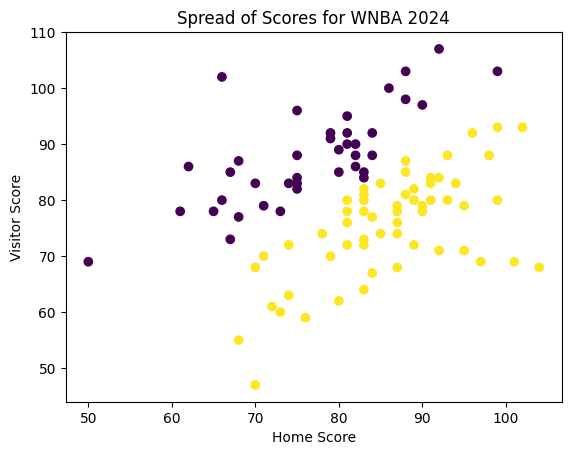

In [71]:
plt.scatter(current_schedule['HomePts'], current_schedule['AwayPts'], c=current_schedule['HomeWin']);
plt.title("Spread of Scores for WNBA 2024");
plt.xlabel("Home Score");
plt.ylabel("Visitor Score");

### How are the Indiana Fever doing compared to the Chicago Sky?

In [72]:
indiana_pt_diff = current_schedule[current_schedule['HomeTeam'] == 'Indiana Fever']['PtsDiff'].mean()
chicago_pt_diff = current_schedule[current_schedule['HomeTeam'] == 'Chicago Sky']['PtsDiff'].mean()

print(f'Indiana Fever Average Point Differential: {indiana_pt_diff}')
print(f'Chicago Sky Average Point Differential: {chicago_pt_diff}')

Indiana Fever Average Point Differential: -4.75
Chicago Sky Average Point Differential: -2.625


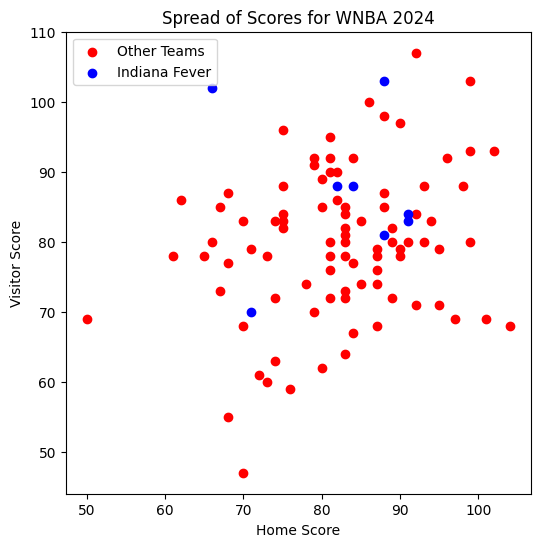

In [89]:
indiana_mask = current_schedule['HomeTeam'] == 'Indiana Fever'
chicago_mask = current_schedule['HomeTeam'] == 'Chicago Sky'
plt.figure(figsize=(6, 6))
plt.scatter(current_schedule.loc[~indiana_mask, 'HomePts'], 
            current_schedule.loc[~indiana_mask, 'AwayPts'],  
            c = 'red',
            label='Other Teams') 

plt.scatter(current_schedule.loc[indiana_mask, 'HomePts'], 
            current_schedule.loc[indiana_mask, 'AwayPts'], 
            c='blue',  
            label='Indiana Fever') 

plt.title("Spread of Scores for WNBA 2024")
plt.xlabel("Home Score")
plt.ylabel("Visitor Score")
plt.legend() 
plt.show()

## Team Strengths Prediction (Normal Model) -- TODO

## Team Strengths Prediction (Thurstone-Mosteller Model) -- TODO

## Game Outcome Predictions (Bradley-Terry Model) -- TODO